In [27]:
"""intent: to make the simplest model and submit to kaggle to have a baseline to start
todo: transfer learning from resnet, 
- scramble final layer
- redo classifer"""


'intent: to make the simplest model and submit to kaggle to have a baseline to start\ntodo: transfer learning from resnet, \n- scramble final layer\n- redo classifer'

setup tasts
rename data/train/train (where the images are)
to data/train/images

In [28]:
from fastai.vision.all import *

In [37]:
import os
import pandas as pd

train_dir = 'data/train/images'
path = Path('data/train/images')
image_files = os.listdir(train_dir)
df = pd.DataFrame({'filename': image_files})
df['id'] = df['filename'].str.split('.').str[0]
print(df.head())

                     filename      id
0  660315.jpg:Zone.Identifier  660315
1                  135654.jpg  135654
2  150810.jpg:Zone.Identifier  150810
3  804916.jpg:Zone.Identifier  804916
4                  759913.jpg  759913


Random row data:
id                  280456
shapeset                 2
type                     1
total_height             5
instability_type         2
cam_angle                1
stable_height            2
Name: 2105, dtype: int64


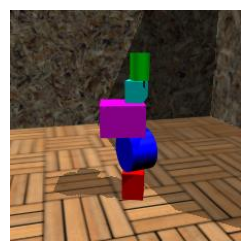

In [30]:
import pandas as pd
import random
from PIL import Image
import os
import matplotlib.pyplot as plt

# Load the data
train_data = pd.read_csv('data/train/train.csv')



# # Pick a random row
# random_row = train_data.sample(n=1).iloc[0]

# Print the data for the random row
print("Random row data:")
print(random_row)

# Display the relevant image
image_path = os.path.join('data', 'train', 'images', f"{random_row['id']}.jpg")
try:
    img = Image.open(image_path)
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print(f"Image not found: {image_path}")

In [31]:
files = get_image_files(train_dir)
len(files)

7680

In [32]:
#ignoring extra info just label
# Assuming you've already loaded your CSV into a DataFrame called 'train_data'
id_to_label = dict(zip(train_data['id'], train_data['stable_height']))

In [42]:


from pathlib import Path

def label_func(file_path):
    if isinstance(file_path, str):
        file_path = Path(file_path)
    file_name = file_path.name
    image_id = file_name.split('.')[0]  # Assumes filenames are like "id.jpg"
    return id_to_label[int(image_id)]

# Test the function
print(label_func(files[0]))

5


In [43]:
path = Path('data/train')

In [44]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

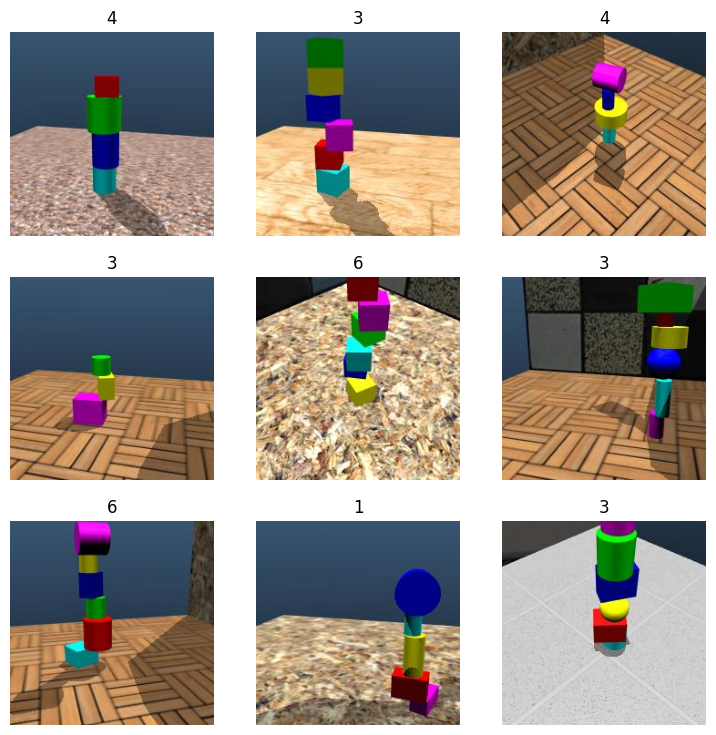

In [45]:
dls.show_batch()

In [47]:
# only adds 1 new layer, probably need to add/scramble more
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,2.627682,1.957407,0.736979,00:16


epoch,train_loss,valid_loss,error_rate,time
0,1.964914,1.724968,0.704427,00:21


## Results Exploration <a name="results-exploration"></a>

<details>
<summary>Click to expand</summary>

</details>


Error rate: 0.704427 means the model's wrong about 70% of the time. For a 6-class problem, that's barely better than random guessing (which would be wrong 83% of the time).

Valid loss: 1.724968 is pretty high. Lower is better, and for a well-performing model, you'd want to see this below 1.

In [48]:
learn.predict(files[0])

('4', tensor(3), tensor([0.0878, 0.1656, 0.0893, 0.3983, 0.1197, 0.1393]))

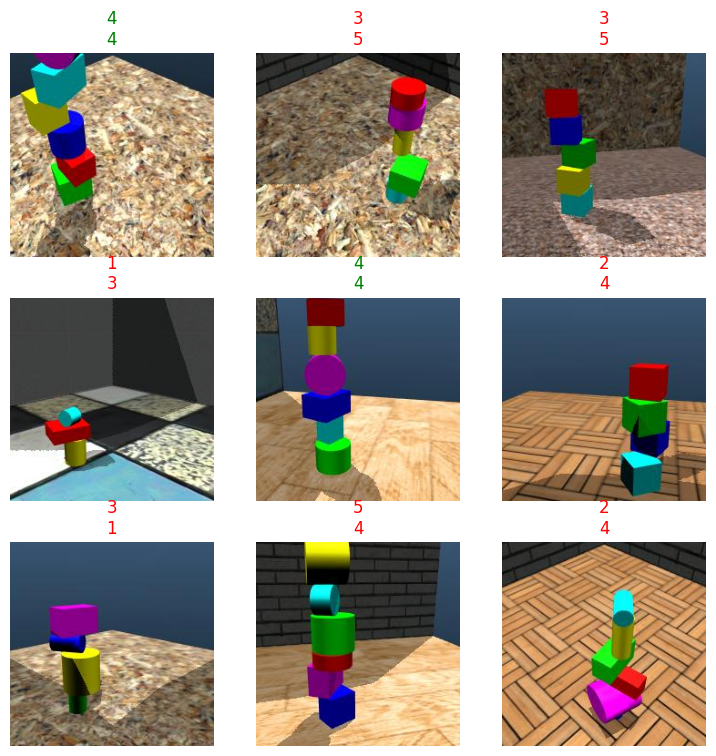

In [49]:
learn.show_results()

1. load the data


## continuing finetuning <a name="results-exploration"></a>

In [51]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,2.610243,1.929828,0.741536,00:17


epoch,train_loss,valid_loss,error_rate,time
0,1.943955,1.675498,0.695964,00:21


SuggestedLRs(valley=4.365158383734524e-05)

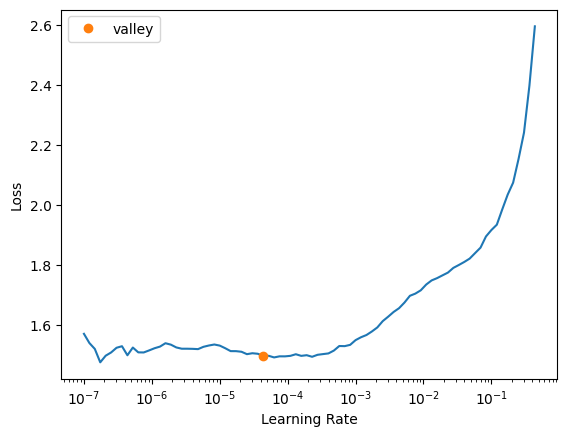

In [52]:
learn.lr_find()

In [53]:
# Let's check the help for learn.fine_tune
help(learn.fine_tune)


Help on method fine_tune in module fastai.callback.schedule:

fine_tune(epochs, base_lr=0.002, freeze_epochs=1, lr_mult=100, pct_start=0.3, div=5.0, *, lr_max=None, div_final=100000.0, wd=None, moms=None, cbs=None, reset_opt=False, start_epoch=0) method of fastai.learner.Learner instance
    Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR.



In [54]:
learn.fine_tune(2, 4e-4)

epoch,train_loss,valid_loss,error_rate,time
0,1.488922,1.642960,0.689453,00:17


epoch,train_loss,valid_loss,error_rate,time
0,1.411176,1.617020,0.680339,00:22
1,1.207737,1.621647,0.659505,00:21


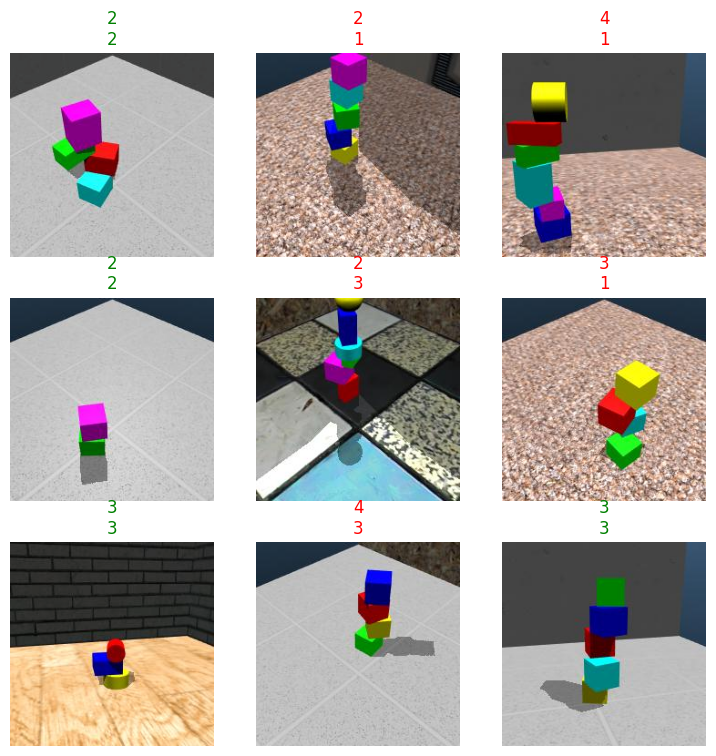

In [55]:
learn.show_results()

In [56]:
interp = Interpretation.from_learner(learn)

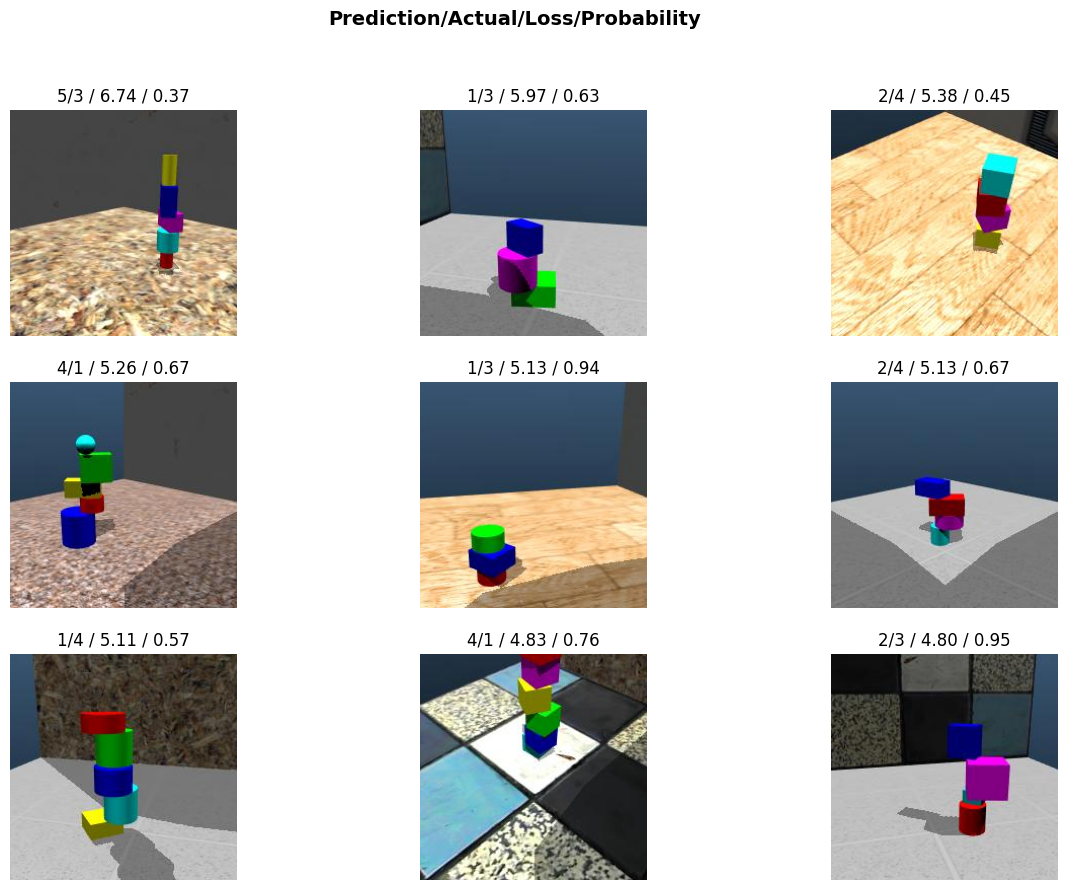

In [57]:
interp.plot_top_losses(9, figsize=(15,10))

In [62]:
print(f"Total layers in the model: {len(list(learn.model.children()))}")
for i, layer in enumerate(learn.model.children()):
    print(f"Layer {i}: {layer.__class__.__name__}")
    if hasattr(layer, 'children'):
        for j, sublayer in enumerate(layer.children()):
            print(f"  Sublayer {j}: {sublayer.__class__.__name__}")




Total layers in the model: 2
Layer 0: Sequential
  Sublayer 0: Conv2d
  Sublayer 1: BatchNorm2d
  Sublayer 2: ReLU
  Sublayer 3: MaxPool2d
  Sublayer 4: Sequential
  Sublayer 5: Sequential
  Sublayer 6: Sequential
  Sublayer 7: Sequential
Layer 1: Sequential
  Sublayer 0: AdaptiveConcatPool2d
  Sublayer 1: Flatten
  Sublayer 2: BatchNorm1d
  Sublayer 3: Dropout
  Sublayer 4: Linear
  Sublayer 5: ReLU
  Sublayer 6: BatchNorm1d
  Sublayer 7: Dropout
  Sublayer 8: Linear


In [63]:
# Display help for learn.freeze_to method
help(learn.freeze_to)



Help on method freeze_to in module fastai.learner:

freeze_to(n) method of fastai.learner.Learner instance
    Freeze parameter groups up to `n`



In [65]:
# Get the parameter groups
param_groups = learn.opt.param_groups

# Print info about each parameter group
for i, group in enumerate(param_groups):
    print(f"Group {i}:")
    print(f"  Learning rate: {group['lr']}")
    print(f"  Number of parameters: {len(group['params'])}")
    print()


Group 0:
  Learning rate: 2.9317677996238163e-10
  Number of parameters: 48

Group 1:
  Learning rate: 2.9317677996229692e-09
  Number of parameters: 60

Group 2:
  Learning rate: 2.931767799623647e-08
  Number of parameters: 6



In [67]:


learn.unfreeze()
learn.freeze_to(-2) # total should be around 34
learn.fine_tune(5, 4e-4)

epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time
0,1.024166,1.673572,0.655599,00:21
1,0.933226,1.746403,0.656250,00:21
2,0.717592,1.815937,0.628906,00:22
3,0.495238,1.891460,0.635417,00:21
4,0.395763,1.894050,0.633464,00:21


In [70]:
# ... existing code ...

# Before creating the DataLoaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# When creating DataLoaders
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224), device=device)

# When creating the learner 
learn = vision_learner(dls, Inception, metrics=error_rate).to(device)

# ... rest of your code ...

Using device: cuda


TypeError: __init__() got an unexpected keyword argument 'pretrained'